In [1]:
pip install cufinufft==2.4.0b1

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 MB 9.4 MB/s eta 0:00:00


In [2]:
import torch
import cupy as cp
import cufinufft
import numpy as np

In [3]:
device = torch.device("cuda:0")
torch.set_default_dtype(torch.float64)

# 1. Package

In [4]:
def conjugate_gradient(A_function, b, x0, tol=1e-10, display=True):
    """
    Solves Ax = b using the Conjugate Gradient method.

    Parameters:
        A : function or matrix
            Matrix or function that computes the product Ax.
        b : ndarray
            Right-hand side vector.
        x0 : ndarray
            Initial guess.
        tol : float
            Tolerance for the stopping criterion.
        max_iter : int
            Maximum number of iterations.

    Returns:
        x : ndarray
            Approximate solution to Ax = b.
    """
    m = b.shape[0]

    x = x0
    r = b - A_function(x)
    p = r.clone()
    rs_old = torch.linalg.vector_norm(r)**2

    for i in range(3*m-2):#A cause de l'embedding pour avoir un circulant: on inverse Cx qui est de taille 3m
        Ap = A_function(p)
        alpha = rs_old / torch.vdot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = torch.linalg.vector_norm(r)**2

        if torch.sqrt(rs_new) < tol:
          if display:
            print(f"CG converged in {i} iterations.")
          break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

In [5]:
def NUFFT_Y(x_gpu, y_gpu, m, threshold):
  n = x_gpu.shape[0]

  f_gpu = cufinufft.nufft1d1(x_gpu, y_gpu, (2*m+1,), eps=threshold)/n

  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor

In [6]:
def kernel_vect(x1_gpu, x2_gpu, m, threshold):
  n = x1_gpu.shape[0]
  y_gpu = cp.ones(n).astype(cp.complex128)

  f_gpu = cufinufft.nufft2d1(x1_gpu, x2_gpu, y_gpu, (2*m+1,2*m+1), eps=threshold)/n#[2*m:, 2*m:]/n
  f_tensor = torch.utils.dlpack.from_dlpack(f_gpu)

  return f_tensor

In [7]:
def A_function(x, lambda_n, mat):
  return mat@ x + lambda_n * x

In [8]:
def NUFFT_inv(x_gpu, f_gpu, threshold):

  y_estimated = cufinufft.nufft1d2(x_gpu, f_gpu, eps=threshold)

  y_estimated = torch.utils.dlpack.from_dlpack(y_estimated)

  return y_estimated

# 2. Experiments

In [11]:
cp.random.seed(seed=1)
torch.manual_seed(1)

d = 5
s = 2

err_N, list_N, time_N = np.array([]), np.array([]), np.array([])

for i in range(1, 17):
  print("i = ", i)

  N = int(10**(i/2))

  x_gpu = cp.random.uniform(size=(d, N), dtype=cp.float64)
  f_gpu = cp.zeros(N, dtype=cp.float64)
  for i in range(d):
    f_gpu += cp.exp(x_gpu[i]/(i+1)) - 1
  y_gpu =  f_gpu.astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)


  lambda_n=N**(-(2*s)/(2*s+1))

  threshold = lambda_n/10

  m = 1+int(N**(1/(2*s+1))/d)
  M = 2*m+1

  torch.cuda.synchronize()
  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)
  start_event.record()

  cov_y = torch.empty(d * M, dtype=torch.complex128, device=device)
  for i in range(d):
    cov_y[i*M:(i+1)*M] = NUFFT_Y(x_gpu[i], y_gpu, m, threshold)

  cov_x = torch.empty((d * M, d * M), dtype=torch.complex128, device=device)

  for i1 in range(d):
      for i2 in range(i1, d):
          cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M] = kernel_vect(x_gpu[i1], -x_gpu[i2], m, threshold)

          if i1 != i2:
              # Assign Hermitian symmetric block (i2, i1)
              cov_x[i2*M:(i2+1)*M, i1*M:(i1+1)*M] = (cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M]).conj().T


  A_funct = lambda x: A_function(x, lambda_n, cov_x)

  hat_theta = conjugate_gradient(A_funct, cov_y, cov_y, threshold)
  print("Error CG ", torch.linalg.norm(A_funct(hat_theta) - cov_y))

  end_event.record()
  torch.cuda.synchronize()
  time_N = np.append(time_N,start_event.elapsed_time(end_event)/10**3)

  N_test = 10**4
  x_test = cp.random.uniform(size=(d, N_test), dtype=cp.float64)
  f_test = cp.zeros(N_test, dtype=cp.float64)

  for i in range(d):
    f_test += cp.exp(x_test[i]/(i+1)) - 1
  y_test =  f_test.astype(cp.complex128)

  estimator = cp.zeros(N_test, dtype=cp.float64)

  for i in range(d):
    estimator += torch.real(NUFFT_inv(x_test[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

  error = torch.tensor((estimator-y_test).get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N = np.append(list_N, N)
  err_N = np.append(err_N, mse)

i =  1
CG converged in 1 iterations.
Error CG  tensor(0.0142, device='cuda:0')
i =  2
CG converged in 2 iterations.
Error CG  tensor(0.0088, device='cuda:0')
i =  3
CG converged in 4 iterations.
Error CG  tensor(0.0015, device='cuda:0')
i =  4
CG converged in 4 iterations.
Error CG  tensor(0.0018, device='cuda:0')
i =  5
CG converged in 6 iterations.
Error CG  tensor(0.0002, device='cuda:0')
i =  6
CG converged in 6 iterations.
Error CG  tensor(0.0003, device='cuda:0')
i =  7
CG converged in 10 iterations.
Error CG  tensor(2.1567e-05, device='cuda:0')
i =  8
CG converged in 11 iterations.
Error CG  tensor(5.9145e-06, device='cuda:0')
i =  9
CG converged in 10 iterations.
Error CG  tensor(1.2914e-05, device='cuda:0')
i =  10
CG converged in 15 iterations.
Error CG  tensor(2.0530e-06, device='cuda:0')
i =  11
CG converged in 15 iterations.
Error CG  tensor(1.2232e-06, device='cuda:0')
i =  12
CG converged in 30 iterations.
Error CG  tensor(7.3845e-07, device='cuda:0')
i =  13
CG converge

In [12]:
with open('results_weakl_gpu.npy', 'wb') as f:
    np.save(f, list_N)
    np.save(f, err_N)
    np.save(f, time_N)

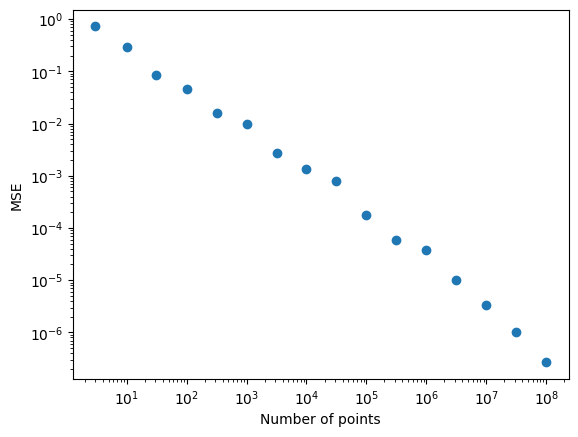

In [13]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")

plt.savefig('Additive.pdf')

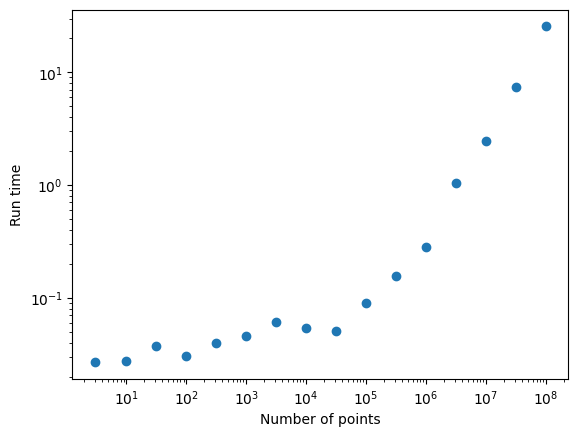

In [14]:
plt.scatter(list_N, time_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("Run time")
plt.show()

# 3- Comparison with PyGAM

## 3.1- PyGAM

In [15]:
pip install pygam

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 80.2/80.2 kB 7.4 MB/s eta 0:00:00


In [16]:
from pygam import LinearGAM, s
import numpy as np
import time

np.random.seed(42)
n_pygam = [int(10**(i/2)) for i in range(2, 14) ]
time_pygam = []
perf_pygam = []
N_test = 10**4
d = 5
smoothness = 2

for n in n_pygam:
  print("n = ", n)
  X = np.random.rand(n, d)
  y = np.zeros(n)
  for i in range(d):
    y += np.exp(X[:, i]/(i+1)) - 1
  y += np.random.randn(n)

  lambda_n=n**(-(2*smoothness)/(2*smoothness+1))
  m = 1+int(n**(1/(2*smoothness+1))/d)
  M = max(4,2*m+1)

  # Set up the model with 5 univariate spline terms
  # 10 splines per term, and lambda = 0.001 for each
  gam = LinearGAM(
      s(0, n_splines=M) +
      s(1, n_splines=M) +
      s(2, n_splines=M) +
      s(3, n_splines=M) +
      s(4, n_splines=M),
      lam=[lambda_n]*5
  )

  # Fit the model
  start = time.time()
  gam.fit(X, y)
  end = time.time()
  time_pygam.append(end-start)

  # Test
  X_test = np.random.rand(N_test, d)
  y_test = np.zeros(N_test)
  for i in range(d):
    y_test += np.exp(X_test[:, i]/(i+1)) - 1
  y_pred = gam.predict(X_test)

  mse = np.mean(np.square(y_pred - y_test))
  perf_pygam.append(mse)

n =  10
n =  31
n =  100
n =  316
n =  1000
n =  3162
n =  10000
n =  31622
n =  100000
n =  316227
n =  1000000
n =  3162277


Memory overload at $N = 10^7$.

In [17]:
with open('results_pygam.npy', 'wb') as f:
    np.save(f, n_pygam)
    np.save(f, time_pygam)
    np.save(f, perf_pygam)

## 3.2 CPU kernel

In [18]:
pip install finufft

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 42.9 MB/s eta 0:00:00


In [19]:
import finufft
def kernel_vect_cpu(x1_gpu, x2_gpu, m, threshold):
  n = x1_gpu.size
  y_gpu = np.ones(n).astype(np.complex128)

  f = finufft.nufft2d1(x1_gpu, x2_gpu, y_gpu, (2*m+1,2*m+1), eps=threshold)/n

  return f

def NUFFT_Y_cpu(x_gpu, y_gpu, m, threshold):
  n = x_gpu.size

  f = finufft.nufft1d1(x_gpu, y_gpu, (2*m+1,), eps=threshold)/n

  return f


def conjugate_gradient_cpu(A_function, b, x0, tol=1e-10, display=True):
    """
    Solves Ax = b using the Conjugate Gradient method.

    Parameters:
        A : function or matrix
            Matrix or function that computes the product Ax.
        b : ndarray
            Right-hand side vector.
        x0 : ndarray
            Initial guess.
        tol : float
            Tolerance for the stopping criterion.
        max_iter : int
            Maximum number of iterations.

    Returns:
        x : ndarray
            Approximate solution to Ax = b.
    """
    m = b.shape[0]

    x = x0
    r = b - A_function(x)
    p = r.copy()
    rs_old = np.linalg.norm(r)**2

    for i in range(3*m-2):#A cause de l'embedding pour avoir un circulant: on inverse Cx qui est de taille 3m
        Ap = A_function(p)
        alpha = rs_old / np.vdot(p, Ap)
        x = x + alpha * p
        r = r - alpha * Ap
        rs_new = np.linalg.norm(r)**2

        if np.sqrt(rs_new) < tol:
          if display:
            print(f"CG converged in {i} iterations.")
          break
        p = r + (rs_new / rs_old) * p
        rs_old = rs_new
    return x

def NUFFT_inv_cpu(x_gpu, f_gpu, threshold):

  y_estimated = finufft.nufft1d2(x_gpu, f_gpu, eps=threshold)

  return y_estimated

In [20]:
import time
np.random.seed(42)

d = 5
s = 2

perf_cpu, n_cpu, time_cpu = np.array([]), np.array([]), np.array([])

for i in range(1, 17):
  print("i = ", i)

  N = int(10**(i/2))

  x_gpu = np.random.uniform(size=(d, N))
  f_gpu = np.zeros(N)
  for i in range(d):
    f_gpu += np.exp(x_gpu[i]/(i+1)) - 1
  y_gpu =  (f_gpu + np.random.normal(size=N)).astype(np.complex128)


  lambda_n=N**(-(2*s)/(2*s+1))
  m = 1+ int(N**(1/(2*s+1))/d)
  M = 2*m+1
  threshold = lambda_n/10


  start = time.time()

  cov_y = np.empty(d * M,  dtype=np.complex128)
  for i in range(d):
    cov_y[i*M:(i+1)*M] = NUFFT_Y_cpu(x_gpu[i], y_gpu, m, threshold)

  cov_x = np.empty((d * M, d * M),  dtype=np.complex128)

  for i1 in range(d):
      for i2 in range(i1, d):
          cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M] = kernel_vect_cpu(x_gpu[i1], -x_gpu[i2], m, threshold)

          if i1 != i2:
              # Assign Hermitian symmetric block (i2, i1)
              cov_x[i2*M:(i2+1)*M, i1*M:(i1+1)*M] = (cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M]).conj().T

  A_funct = lambda x: A_function(x, lambda_n, cov_x)

  hat_theta = conjugate_gradient_cpu(A_funct, cov_y, cov_y, threshold).astype(np.complex128)
  print("Error CG ", np.linalg.norm(A_funct(hat_theta) - cov_y))

  end = time.time()
  time_cpu = np.append(time_cpu, end-start)

  N_test = 10**4
  x_test = np.random.uniform(size=(d, N_test))
  f_test = np.zeros(N_test)

  for i in range(d):
    f_test += np.exp(x_test[i]/(i+1)) - 1
  y_test =  f_test.astype(np.complex128)

  estimator = np.zeros(N_test)

  for i in range(d):
    estimator += np.real(NUFFT_inv_cpu(x_test[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

  error = estimator-y_test
  mse = np.mean(np.square(np.abs(error)))


  n_cpu = np.append(n_cpu, N)
  perf_cpu = np.append(perf_cpu, mse)

i =  1
CG converged in 1 iterations.
Error CG  0.00256168783885033
i =  2
CG converged in 2 iterations.
Error CG  0.005295337629061095
i =  3
CG converged in 4 iterations.
Error CG  0.003319984941882855
i =  4
CG converged in 4 iterations.
Error CG  0.00033924730721735023
i =  5
CG converged in 6 iterations.
Error CG  0.000172465796778723
i =  6
CG converged in 7 iterations.
Error CG  0.00015749933287393042
i =  7
CG converged in 10 iterations.
Error CG  7.633151299386586e-05
i =  8
CG converged in 11 iterations.
Error CG  3.829655855485231e-06
i =  9
CG converged in 11 iterations.
Error CG  5.198120195574016e-06
i =  10
CG converged in 15 iterations.
Error CG  1.3058578680000675e-06
i =  11
CG converged in 15 iterations.
Error CG  1.597498963226106e-06
i =  12
CG converged in 24 iterations.
Error CG  1.4466569348200125e-06
i =  13
CG converged in 28 iterations.
Error CG  5.403071380604758e-07
i =  14
CG converged in 33 iterations.
Error CG  1.4145608214797922e-07
i =  15
CG converged 

In [21]:
with open('results_kernel_cpu.npy', 'wb') as f:
    np.save(f, n_cpu)
    np.save(f, time_cpu)
    np.save(f, perf_cpu)

## 3.3 Plots

In [22]:
with open('results_weakl_gpu.npy', 'rb') as f:
    n_gpu = np.load(f)
    perf_gpu = np.load(f)
    time_gpu = np.load(f)

with open('results_kernel_cpu.npy', 'rb') as f:
    n_cpu = np.load(f)
    time_cpu = np.load(f)
    perf_cpu = np.load(f)

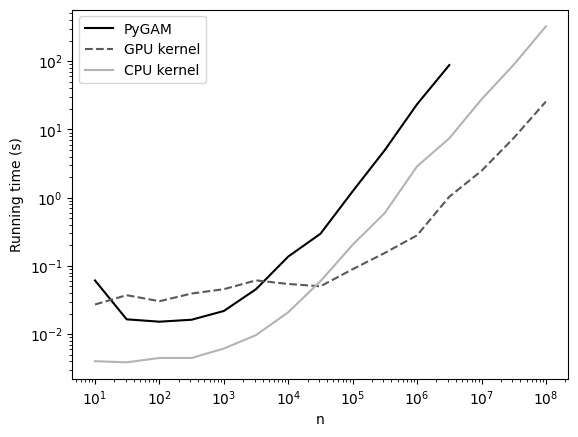

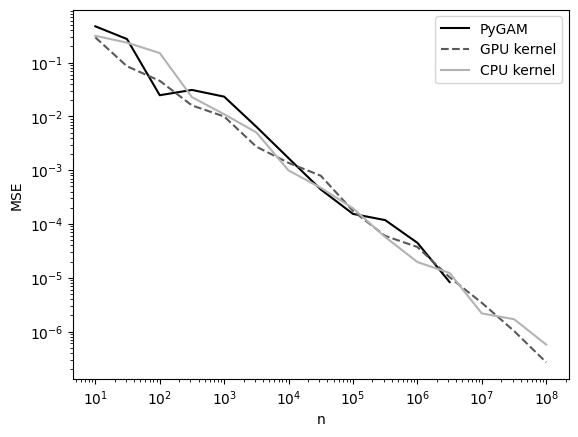

In [30]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = [cm.gray(x) for x in np.linspace(0, 0.7, 3)]

plt.plot(n_pygam, time_pygam, label="PyGAM", color=colors[0])
plt.plot(n_gpu[1:], time_gpu[1:], linestyle = "--", label="GPU kernel", color=colors[1])
plt.plot(n_cpu[1:], time_cpu[1:],  label="CPU kernel", color=colors[2])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("n")
plt.ylabel("Running time (s)")
plt.savefig('Additive-runtime.pdf')
plt.show()

plt.plot(n_pygam, perf_pygam, label="PyGAM", color=colors[0])
plt.plot(n_gpu[1:], perf_gpu[1:], linestyle = "--", label="GPU kernel", color=colors[1])
plt.plot(n_cpu[1:], perf_cpu[1:],  label="CPU kernel", color=colors[2])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("n")
plt.savefig('Additive-perf.pdf')
plt.show()

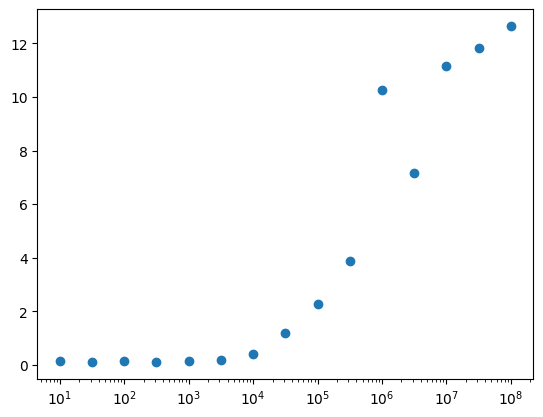

In [31]:
plt.scatter(n_gpu[1:], time_cpu[1:]/time_gpu[1:])
plt.xscale('log')
plt.savefig('GPU-speedup.pdf')
plt.show()

#4 - Grid search

## 4.1 - GPU kernel

In [32]:
cp.random.seed(seed=1)
torch.manual_seed(1)

d = 5
s = 2

err_N, list_N, time_N = np.array([]), np.array([]), np.array([])
lambda_N_list = [10**(-i/10) for i in range(300)]

for i in range(1, 17):#17):
  print("i = ", i)

  ##### Training data
  N = int(10**(i/2))

  x_gpu = cp.random.uniform(size=(d, N), dtype=cp.float64)
  f_gpu = cp.zeros(N, dtype=cp.float64)
  for i in range(d):
    f_gpu += cp.exp(x_gpu[i]/(i+1)) - 1
  y_gpu =  f_gpu.astype(cp.complex128) + cp.random.normal(size=N).astype(cp.complex128)

  threshold = N**(-2*s/(2*s+1))/10

  m = 1+int(N**(1/(2*s+1))/d)
  M = 2*m+1

  ##### Validation data
  N_val = min(N, 10**4)
  x_val = cp.random.uniform(size=(d, N_val), dtype=cp.float64)
  f_val = cp.zeros(N_val, dtype=cp.float64)
  for i in range(d):
    f_val += cp.exp(x_val[i]/(i+1)) - 1
  y_val =  f_val.astype(cp.complex128) + cp.random.normal(size=N_val).astype(cp.complex128)
  err_val = torch.inf

  ##### Fitting
  torch.cuda.synchronize()
  start_event = torch.cuda.Event(enable_timing=True)
  end_event = torch.cuda.Event(enable_timing=True)
  start_event.record()

  cov_y = torch.empty(d * M, dtype=torch.complex128, device=device)
  for i in range(d):
    cov_y[i*M:(i+1)*M] = NUFFT_Y(x_gpu[i], y_gpu, m, threshold)

  cov_x = torch.empty((d * M, d * M), dtype=torch.complex128, device=device)

  for i1 in range(d):
      for i2 in range(i1, d):
          cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M] = kernel_vect(x_gpu[i1], -x_gpu[i2], m, threshold)

          if i1 != i2:
              # Assign Hermitian symmetric block (i2, i1)
              cov_x[i2*M:(i2+1)*M, i1*M:(i1+1)*M] = (cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M]).conj().T


  for lambda_n in lambda_N_list:
    A_funct = lambda x: A_function(x, lambda_n, cov_x)

    if lambda_n == lambda_N_list[0]:
      hat_theta = conjugate_gradient(A_funct, cov_y, cov_y, threshold, display=False)
      hat_theta_last = hat_theta
    else:
      hat_theta = conjugate_gradient(A_funct, cov_y, hat_theta_last, threshold, display=False)
      hat_theta_last = hat_theta
    #print("Error CG ", torch.linalg.norm(A_funct(hat_theta) - cov_y))

    estimator_val = cp.zeros(N_val, dtype=cp.float64)
    for i in range(d):
      estimator_val += torch.real(NUFFT_inv(x_val[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

    error = torch.tensor((estimator_val-y_val).get(), dtype=torch.float64)
    mse = torch.mean(torch.square(torch.abs(error)))
    if mse <err_val:
      err_val = mse
      hat_theta_val = hat_theta

  end_event.record()
  torch.cuda.synchronize()
  time_N = np.append(time_N,start_event.elapsed_time(end_event)/10**3)

  N_test = 10**4
  x_test = cp.random.uniform(size=(d, N_test), dtype=cp.float64)
  f_test = cp.zeros(N_test, dtype=cp.float64)

  for i in range(d):
    f_test += cp.exp(x_test[i]/(i+1)) - 1
  y_test =  f_test.astype(cp.complex128)

  estimator = cp.zeros(N_test, dtype=cp.float64)

  for i in range(d):
    estimator += torch.real(NUFFT_inv(x_test[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

  error = torch.tensor((estimator-y_test).get(), dtype=torch.float64)
  mse = torch.mean(torch.square(torch.abs(error)))

  list_N = np.append(list_N, N)
  err_N = np.append(err_N, mse)

i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15
i =  16


Text(0, 0.5, 'MSE')

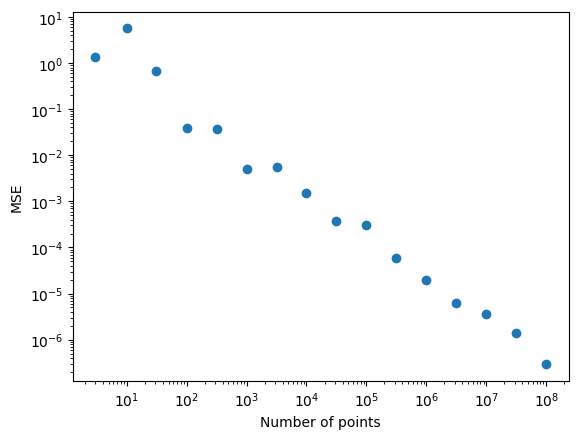

In [33]:
import matplotlib.pyplot as plt

plt.scatter(list_N, err_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("MSE")


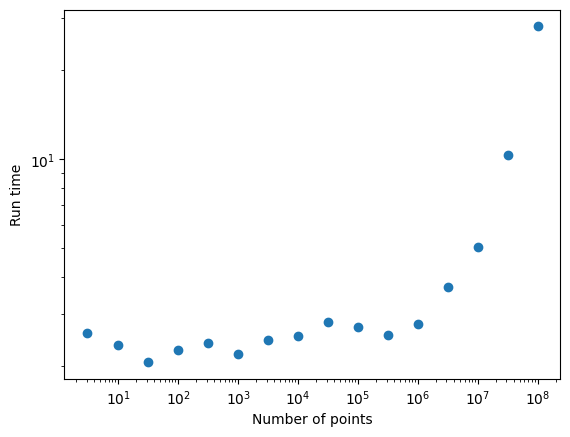

In [34]:
plt.scatter(list_N, time_N)
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Number of points")
plt.ylabel("Run time")
plt.show()

In [35]:
with open('results_weakl_gpu_gs.npy', 'wb') as f:
    np.save(f, list_N)
    np.save(f, err_N)
    np.save(f, time_N)

## 4.2 - CPU kernel

In [36]:
import time
np.random.seed(42)

d = 5
s = 2

perf_cpu, n_cpu, time_cpu = np.array([]), np.array([]), np.array([])
lambda_N_list = [10**(-i/10) for i in range(300)]

for i in range(1, 16):#17):
  print("i = ", i)

  ##### Training data
  N = int(10**(i/2))


  x_gpu = np.random.uniform(size=(d, N))
  f_gpu = np.zeros(N)
  for i in range(d):
    f_gpu += np.exp(x_gpu[i]/(i+1)) - 1
  y_gpu =  (f_gpu + np.random.normal(size=N)).astype(np.complex128)

  threshold = N**(-2*s/(2*s+1))/10

  m = 1+int(N**(1/(2*s+1))/d)
  M = 2*m+1

  ##### Validation data
  N_val = min(N, 10**4)
  x_val = np.random.uniform(size=(d, N_val))
  f_val = np.zeros(N_val)
  for i in range(d):
    f_val += np.exp(x_val[i]/(i+1)) - 1
  y_val =  (f_val + np.random.normal(size=N_val)).astype(np.complex128)

  err_val = np.inf

  ##### Fitting
  start = time.time()

  cov_y = np.empty(d * M,  dtype=np.complex128)
  for i in range(d):
    cov_y[i*M:(i+1)*M] = NUFFT_Y_cpu(x_gpu[i], y_gpu, m, threshold)

  cov_x = np.empty((d * M, d * M),  dtype=np.complex128)

  for i1 in range(d):
      for i2 in range(i1, d):
          cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M] = kernel_vect_cpu(x_gpu[i1], -x_gpu[i2], m, threshold)

          if i1 != i2:
              # Assign Hermitian symmetric block (i2, i1)
              cov_x[i2*M:(i2+1)*M, i1*M:(i1+1)*M] = (cov_x[i1*M:(i1+1)*M, i2*M:(i2+1)*M]).conj().T


  for lambda_n in lambda_N_list:
    A_funct = lambda x: A_function(x, lambda_n, cov_x)

    if lambda_n == lambda_N_list[0]:
      hat_theta = conjugate_gradient_cpu(A_funct, cov_y, cov_y, threshold, display=False).astype(np.complex128)
      hat_theta_last = hat_theta
    else:
      hat_theta = conjugate_gradient_cpu(A_funct, cov_y, cov_y, threshold, display=False).astype(np.complex128)
      hat_theta_last = hat_theta

    estimator_val = np.zeros(N_val)
    for i in range(d):
      estimator_val += np.real(NUFFT_inv_cpu(x_val[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

    error = estimator_val-y_val
    mse = np.mean(np.square(np.abs(error)))
    if mse <err_val:
      err_val = mse
      hat_theta_val = hat_theta

  end = time.time()
  time_cpu = np.append(time_cpu, end-start)

  ###
  N_test = 10**4
  x_test = np.random.uniform(size=(d, N_test))
  f_test = np.zeros(N_test)

  for i in range(d):
    f_test += np.exp(x_test[i]/(i+1)) - 1
  y_test =  f_test.astype(np.complex128)

  estimator = np.zeros(N_test)

  for i in range(d):
    estimator += np.real(NUFFT_inv_cpu(x_test[i], hat_theta[(2*m+1)*i:(2*m+1)*(i+1)], threshold))

  error = estimator-y_test
  mse = np.mean(np.square(np.abs(error)))

  n_cpu = np.append(n_cpu, N)
  perf_cpu = np.append(perf_cpu, mse)

i =  1
i =  2
i =  3
i =  4
i =  5
i =  6
i =  7
i =  8
i =  9
i =  10
i =  11
i =  12
i =  13
i =  14
i =  15


In [37]:
with open('results_kernel_cpu_gs.npy', 'wb') as f:
    np.save(f, n_cpu)
    np.save(f, time_cpu)
    np.save(f, perf_cpu)

## 4.3 - PyGAM

In [38]:
from pygam import LinearGAM, s
import numpy as np
import time

np.random.seed(42)
n_pygam = [int(10**(i/2)) for i in range(2, 10)]
time_pygam = []
perf_pygam = []
N_test = 10**4
d = 5
smoothness = 2

lambda_N_list = [[10**(-i/10)]*d for i in range(300)]
lam_grid = np.array(lambda_N_list)

for n in n_pygam:
  print("\n n = ", n, "\n")
  X = np.random.rand(n, d)
  y = np.zeros(n)
  for i in range(d):
    y += np.exp(X[:, i]/(i+1)) - 1
  y += np.random.randn(n)

  m = 1+int(n**(1/(2*smoothness+1))/d)
  M = max(4,2*m+1)

  # Set up the model with 5 univariate spline terms
  # 10 splines per term, and lambda = 0.001 for each
  base_gam = LinearGAM(
      s(0, n_splines=M) +
      s(1, n_splines=M) +
      s(2, n_splines=M) +
      s(3, n_splines=M) +
      s(4, n_splines=M)
  )

  # Fit the model
  start = time.time()
  gam = base_gam.gridsearch(X=X, y=y, lam = lam_grid)
  end = time.time()
  time_pygam.append(end-start)

  # Test
  X_test = np.random.rand(N_test, d)
  y_test = np.zeros(N_test)
  for i in range(d):
    y_test += np.exp(X_test[:, i]/(i+1)) - 1
  y_pred = gam.predict(X_test)

  mse = np.mean(np.square(y_pred - y_test))
  perf_pygam.append(mse)

  4% (12 of 300) |                       | Elapsed Time: 0:00:00 ETA:   0:00:04


 n =  10 



100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  4% (12 of 300) |                       | Elapsed Time: 0:00:00 ETA:   0:00:04


 n =  31 



100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  2% (8 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05


 n =  100 



100% (300 of 300) |######################| Elapsed Time: 0:00:05 Time:  0:00:05
  2% (8 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:05


 n =  316 



100% (300 of 300) |######################| Elapsed Time: 0:00:04 Time:  0:00:04
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:09


 n =  1000 



100% (300 of 300) |######################| Elapsed Time: 0:00:09 Time:  0:00:09
  1% (4 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:13


 n =  3162 



100% (300 of 300) |######################| Elapsed Time: 0:00:14 Time:  0:00:14
  0% (1 of 300) |                        | Elapsed Time: 0:00:00 ETA:   0:00:31


 n =  10000 



100% (300 of 300) |######################| Elapsed Time: 0:00:28 Time:  0:00:28
  0% (0 of 300) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--


 n =  31622 



100% (300 of 300) |######################| Elapsed Time: 0:01:20 Time:  0:01:20


In [39]:
with open('results_pygam_gs.npy', 'wb') as f:
    np.save(f, n_pygam)
    np.save(f, time_pygam)
    np.save(f, perf_pygam)

## 4.4 - Plots

In [40]:
with open('results_weakl_gpu_gs.npy', 'rb') as f:
    n_gpu = np.load(f)
    perf_gpu = np.load(f)
    time_gpu = np.load(f)

with open('results_pygam_gs.npy', 'rb') as f:
    n_pygam = np.load(f)
    time_pygam = np.load(f)
    perf_pygam = np.load(f)

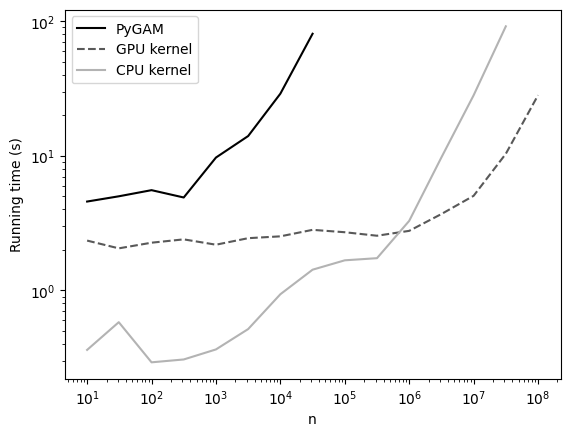

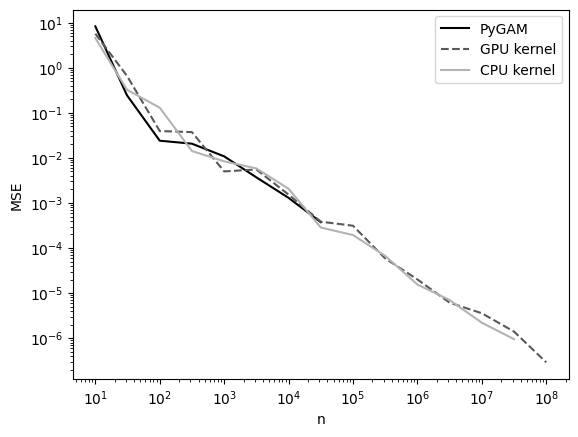

In [42]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm

colors = [cm.gray(x) for x in np.linspace(0, 0.7, 3)]

plt.plot(n_pygam, time_pygam, label="PyGAM", color=colors[0])
plt.plot(n_gpu[1:], time_gpu[1:], linestyle = "--", label="GPU kernel", color=colors[1])
plt.plot(n_cpu[1:], time_cpu[1:],  label="CPU kernel", color=colors[2])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.xlabel("n")
plt.ylabel("Running time (s)")
plt.savefig('Additive-runtime_gs.pdf')
plt.show()

plt.plot(n_pygam, perf_pygam, label="PyGAM", color=colors[0])
plt.plot(n_gpu[1:], perf_gpu[1:], linestyle = "--", label="GPU kernel", color=colors[1])
plt.plot(n_cpu[1:], perf_cpu[1:],  label="CPU kernel", color=colors[2])
plt.xscale('log')
plt.yscale('log')
plt.legend()
plt.ylabel("MSE")
plt.xlabel("n")
plt.savefig('Additive-perf-gs.pdf')
plt.show()